In [118]:
import importlib
import Policy 
import Environment
import Diadic

importlib.reload(Policy)
importlib.reload(Environment)
importlib.reload(Diadic)

<module 'Diadic' from '/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Diadic.py'>

In [119]:
class Simulator :
    def __init__(self, algo, env, T) -> None:
        self.algo = algo
        self.env = env
        self.T = T
    
    def run(self):
        for t in range(self.T) :
            x_t = self.algo.choose_action()
            y_t = self.env.get_reward(t, x_t)
            self.algo.update(x_t, y_t)

Entering Episode 1
Entering Block 3


/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Policy.py:247: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


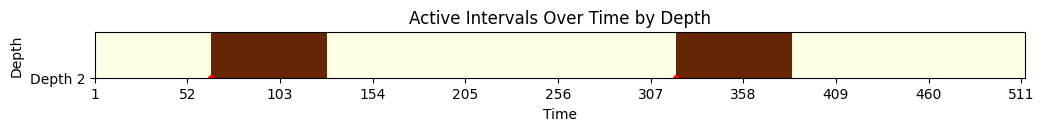

In [120]:
T = 5000
env = Environment.Environment(T, 3)
algo = Policy.MBDE(T)

algo.initialize_episode()
algo.initialize_block()
#algo.tree.activate_depth(2) # TODO: change
algo.tree.update_proba()
#algo.tree.visualize_tree()

algo.tree.visualize()
sim = Simulator(algo, env, T)


Entering Block 4


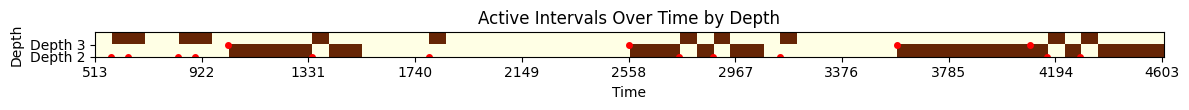

Node (4, 1) evicted at t=649 (Replay(4))
Node (4, 1) evicted at t=832 (Replay(2))
Node (4, 8) evicted at t=1243 (Replay(4))
Node (4, 1) evicted at t=1280 (Replay(2))
Node (4, 8) evicted at t=1280 (Replay(2))
Node (4, 1) evicted at t=1280 (Replay(2))
Node (4, 7) evicted at t=1722 (Replay(4))
Node (4, 6) evicted at t=1986 (Replay(4))


In [121]:
sim.run()

In [122]:
len(sim.algo.tree.active_depths)

1

In [123]:
sim.algo.B_MASTER

[(4,4), (4,5), (4,2), (4,3)]

In [124]:
sim.algo.tree.visualize()

In [85]:
sim.algo.B_MASTER

[(3,2), (3,3), (3,4)]

In [61]:
sim.algo.StoreActive

defaultdict(dict,
            {4: {'starting': 513, 'ending': 4609},
             2: {'starting': 1216, 'ending': 1280},
             3: {'starting': 1536, 'ending': 2048}})